# QF605 | Fixed Income Securities Project
#### Members
1. Jung Hyung-yun
2. Lim Jeng
3. Nguyen Ngo Duy Quang
4. Shao Jiayu
5. Sun Qiaozhen
6. Tan Hui Shan
7. Tan Wei Hao

## Part I (Bootstrapping Swap Curves)

1. In the `IR Data.xlsm` spreadsheeet, OIS data is provided. Bootstrap the
OIS discount factor $D_o (0, T)$ and plot the discount curve for $T ∈ [0, 30]$.
2. Using the IRS data provided, bootstrap the LIBOR discount factor
$D(0, T)$, and plot it for $T ∈ [0, 30]$.
> ⇒ Assume that the swap market is collateralized in cash and overnight
interest is paid on collateral posted.

3. Calculate the following forward swap rates:
>• $1y × 1y, 1y × 2y, 1y × 3y, 1y × 5y, 1y × 10y$
>
>• $5y × 1y, 5y × 2y, 5y × 3y, 5y × 5y, 5y × 10y$
>
>• $10y × 1y, 10y × 2y, 10y × 3y, 10y × 5y, 10y × 10y$

In [2]:
# Libraries
import pandas as pd
import numpy as np
from scipy.optimize import brentq
from scipy.interpolate import interp2d
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### Part 1.
In the `IR Data.xlsm` spreadsheeet, OIS data is provided. Bootstrap the
OIS discount factor $D_o (0, T)$ and plot the discount curve for $T ∈ [0, 30]$.

In [4]:
# Data
# Reading from excel.
OIS_data =\
(
    pd
    .read_excel("IR Data.xlsx", 
                sheet_name = "OIS"
               )
)

# Retrieve relevant columns: Tenors and Rates.
OIS_data =\
(
    OIS_data
    [["Tenor","Rate"]]
)

# Changing tenors to numeric results for operations
OIS_data["Tenor"] =\
(
    OIS_data
    ["Tenor"]
    .str[:-1]
)

OIS_data["Tenor"] =\
(
    OIS_data
    ["Tenor"]
    .astype(float)
)

OIS_data["Rate"] =\
(
    OIS_data
    ["Rate"]
    .astype(float)
)

# Manually changing 6m to 0.5y
OIS_data.iloc[0:1, 0] = 0.5

OIS_data.head()

,Tenor,Rate
0,0.5,0.00250
1,1.0,0.00300
2,2.0,0.00325
3,3.0,0.00335
4,4.0,0.00350


Calculating $D_O(0,6m)$ and $f_0$:

$$
\begin{align}
D_O(0,6m) &= \frac{1}{(1 + \frac{OIS_{6m}}{360})^{180}} \\
f_0 &= 360 \times \left[(0.5\times OIS_{6m} + 1 )^{\frac{1}{180}}-1\right]
\end{align}
$$

In [6]:
ois_6m =\
(
    OIS_data
    .iloc[0]["Rate"]
)

### Calculating D(0,6m)
d06m =\
(
    1 
    / 
    (1 + ois_6m/360)**180
)

print("d06m:", d06m)

### Calculating f0 f(0,6m)
f0 =\
(
    360 * ( ((0.5 * ois_6m) + 1)**(1/180) - 1)
)

print("f0:", f0)

d06m: 0.9987507852594284
f0: 0.0024984474705913584


Calculating $D_O(0,1y)$ and $f_1$:

$$
\begin{align}
D_O(0,6m) &= \frac{1}{(1 + \frac{f_{0}}{360})^{180} \times (1 + \frac{f_{1}}{360})^{180}} \\
f_1 &= 360 \times \left[\left(\frac{OIS_{1y} + 1}{(1+ \frac{f_0}{360})^{180}}\right)^{\frac{1}{180}} - 1 \right]
\end{align}
$$

In [8]:
ois_1y =\
(
    OIS_data
    .iloc[1]["Rate"]
)

### Calculating f1 f(6m,1y)
f1 =\
(
    360 * (
                ( (ois_1y+1)
                  /
                  ( (1 + f0/360)**180 )
                )**(1/180)-1
          )
)
print("f1:", f1)

### Calculating D01y
d01y =\
(
    1 
    / 
    ( (1 + f0/360)**180 * (1 + f1/360)**180 )
)
print("d01y:", d01y)

f1: 0.0034925961006493367
d01y: 0.9970089730807411


Functions to calculate Forward rate using $PV_{fixed} - PV_{float} = 0$

$$
\begin{align}
    D_{current} &= \left(\frac{D_O}{1 + \frac{f}{360}}\right)^{360} \\
    PV_{fix} &= \left[\sum D_0(0, t_i) + D_{current}\right] \times OIS_{current} \\
    PV_{float} &= \sum D_0(0, t_i) \times OIS_{previous} + D_{current} \times \left[\left(1 + \frac{f}{360}\right)^{360} -1 \right] \\
\end{align}
$$

We assume flat OIS rate from the latest OIS rate for those tenors with missing OIS.

In [10]:
def calculateForward(row_index, 
                     forward_rate, 
                     oisDiscFactor):
    d_current =\
    (
        oisDiscFactor[-1] 
        / 
        ( (1 + forward_rate/360)**360 )
    )

    pv_fixed =\
    (
        (sum(oisDiscFactor) + d_current) 
        * 
        OIS_data['Rate'].iloc[row_index]
    )

    pv_float =\
    (
        sum(oisDiscFactor) * OIS_data['Rate'].iloc[row_index-1]
        + 
        d_current * ((1 + forward_rate/360)**360 -1)
    )

    return pv_fixed - pv_float

def calculateForwardNoOis(row_index, 
                          forward_rate, 
                          num_inbetween, 
                          oisDiscFactor):
    d_list =\
    [
        oisDiscFactor[-1] 
        / 
        (1 + forward_rate/360)**(360 * n) for n in range(1, num_inbetween+1)
    ]

    pv_fixed =\
    (
        (sum(oisDiscFactor) + sum(d_list)) 
        * 
        OIS_data['Rate'].iloc[row_index]
    )

    pv_float =\
    (
        sum(oisDiscFactor) * OIS_data['Rate'].iloc[row_index-1]
        + 
        sum(d_list) * ((1 + forward_rate/360)**360 -1)
    )

    return pv_fixed - pv_float

In [11]:
### Initialize oisDiscFactor and forward rates to add to with each iteration

oisDiscFactor = [d01y]
forwardRates = [f1]


### Loooping from index 2 (2y Tenor) to index 10 (30y Tenor) +1 to include last
for index in range(2, 10+1):

    diff =\
    (
        int(
            OIS_data["Tenor"].iloc[index] 
            - 
            OIS_data["Tenor"].iloc[index-1]
        )
    )

    if diff == 1:
        objective_function =\
        (
            lambda forward_rate: calculateForward(index, 
                                                  forward_rate, 
                                                  oisDiscFactor
                                                 )
        )
        
        current_forward_rate =\
        (
            brentq(objective_function, 
                   -10, 
                   20
                  )
        )

        # update lists
        oisDiscFactor\
            .append(oisDiscFactor[-1]
                    /
                    ((1 + current_forward_rate/360)**360)
                   )
        
        forwardRates\
            .append(current_forward_rate)

    else:
        objective_function =\
        (
            lambda forward_rate: calculateForwardNoOis(index, 
                                                       forward_rate, 
                                                       diff, 
                                                       oisDiscFactor
                                                      )
        )
        
        current_forward_rate =\
        (
            brentq(objective_function, 
                   -10, 
                   20
                  )
        )

        # update lists
        new_oisDiscFactor =\
        [
            oisDiscFactor[-1]
            /
            ((1 + current_forward_rate/360)**(360*n)) for n in range(1, diff+1)
        ]
        
        new_forward_rates =\
        [
            current_forward_rate for n in range(1, diff+1)
        ]
        
        oisDiscFactor\
            .extend(new_oisDiscFactor)
        
        forwardRates\
            .extend(new_forward_rates)

# print(oisDiscFactor)
# print(forwardRates)

In [12]:
# interpolating 0.5 year oisDiscountFactors 

oisDiscFactor_all = [d06m, d01y]

for original_index in range(1,len(oisDiscFactor)):
    currentDiscount = oisDiscFactor_all[-1]
    nextFullYearDiscount = oisDiscFactor[original_index]
    nextHalfYearDiscount = (nextFullYearDiscount + currentDiscount) /2
    oisDiscFactor_all.append(nextHalfYearDiscount)
    oisDiscFactor_all.append(nextFullYearDiscount)

# add D(0,0) for reference consistency
oisDiscFactor_all = [1] + oisDiscFactor_all

In [13]:
T_values =\
[
    i * 0.5 for i in range(len(oisDiscFactor_all))
]

oisDiscFactorsDF =\
(
    pd
    .DataFrame({'T': T_values, 
                'DiscountFactor': oisDiscFactor_all}
              )
)

oisDiscFactorsDF.set_index("T")

,DiscountFactor
T,
0.0,1.000000
0.5,0.998751
1.0,0.997009
1.5,0.995270
2.0,0.993531
...,...
28.0,0.857703
28.5,0.855126
29.0,0.852548


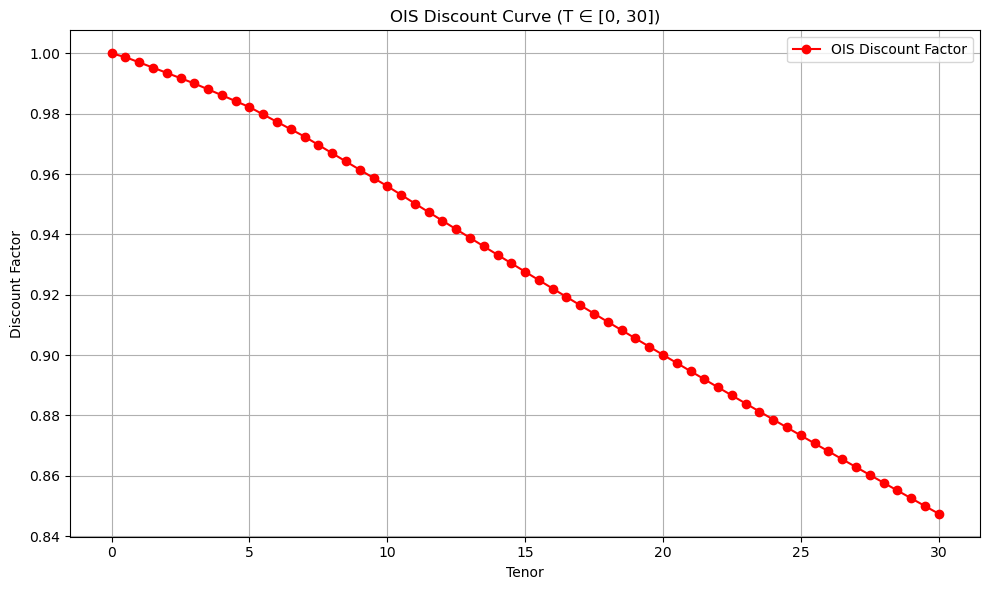

In [14]:
# Plot the OIS discount curve
plt\
    .figure(figsize = (10, 6)
           )

plt\
    .plot(T_values, 
          oisDiscFactor_all, 
          marker = "o", 
          linestyle = "-", 
          color = "red",
          label = "OIS Discount Factor"
         )

plt\
    .title("OIS Discount Curve (T ∈ [0, 30])"
          )
plt\
    .xlabel("Tenor")
plt\
    .ylabel("Discount Factor")
plt\
    .grid(True)
plt\
    .legend()
plt\
    .tight_layout()
plt\
    .show()

### Part 2. 
Using the IRS data provided, bootstrap the LIBOR discount factor
$D(0, T)$, and plot it for $T ∈ [0, 30]$.
> ⇒ Assume that the swap market is collateralized in cash and overnight
interest is paid on collateral posted.

In [16]:
# Data
# Reading from excel.
IRS_data =\
(
    pd
    .read_excel("IR Data.xlsx", 
                sheet_name = "IRS"
               )
)

# Retrieve relevant columns: Tenors and Rates.
IRS_data =\
(
    IRS_data
    [["Tenor","Rate"]]
)

# Changing tenors to numeric results for operations
IRS_data["Tenor"] =\
(
    IRS_data
    ["Tenor"]
    .str[:-1]
)

IRS_data["Tenor"] =\
(
    IRS_data
    ["Tenor"]
    .astype(float)
)

IRS_data["Rate"] =\
(
    IRS_data
    ["Rate"]
    .astype(float)
)

# Manually changing 6m to 0.5y
IRS_data.iloc[0:1, 0] = 0.5

IRS_data.head()

,Tenor,Rate
0,0.5,0.0250
1,1.0,0.0280
2,2.0,0.0300
3,3.0,0.0315
4,4.0,0.0325


Functions to calculate Libor Discount Factor:

$$
\begin{align}
    PV_{fix} &= 0.5 \times \sum D_0(0, t_i) \times \text{fixed rate} \\
    PV_{float} &= 0.5 \times \sum D_0(0, t_i) \times L(t_{i-1}, t_i)
\end{align}
$$

Note $0.5$ is due to semi-annual.

In [18]:
def calculateLiborDisc(oisDiscFactor, 
                       liborFwdRates, 
                       fixedRate, 
                       prevDiscount, 
                       discountFactor, # objective variable
                       numYear): 
    pv_fixed =\
    (
        0.5 
        * 
        sum(oisDiscFactor[1:int(numYear)*2+1]) 
        * 
        fixedRate
    )
    
    pv_float = 0

    # -2 because for year 3, you would only have 
    # libfwd rates for [(0,0), (0,6m), (6m,1y), (1y,1.5y), (1.5y, 2y)]
    limit =\
    (
        len(liborFwdRates) - 2
    )

    # linear interpolation
    tempDiff = (prevDiscount - discountFactor) / 2 
    
    tempPrev = prevDiscount
    
    for index in range(int(numYear) *  2):
        if index <= limit:

            # within limit means summing until the prev period, 
            # e.g. to calculate year 3, your limit for forward rates is until year 2
            pv_float += 0.5 * oisDiscFactor[index+1] * liborFwdRates[index+1]
    
        else:
            
            # D(0, 2.5) = D(0,2) - ( D(0,2) - D(0, 2.5) ) / D(0, 2.5)
            # D(0, 2.5) = (D(0,3) + D(0,2)) / 2 
            # tempPrev D(0, 2) - diff(D(0,2) and D(0,2.5) = D(0, 2.5) 
            pv_float += (tempPrev - (tempPrev - tempDiff)) / (tempPrev - tempDiff) * oisDiscFactor[index+1]

            # update now tempPrev is D(0, 2.5) for the calculation of D(0, 3)
            tempPrev = prevDiscount-tempDiff 
            
    return pv_fixed - pv_float

def calculateLiborDiscWithoutIRS(oisDiscFactor, 
                                 liborFwdRates, 
                                 numHalfYear, 
                                 fixedRate, 
                                 prevDiscount, 
                                 discountFactor, # objective variable
                                 numYear): 
    
    pv_fixed = 0.5 * sum(oisDiscFactor[1:int(numYear)*2+1]) * fixedRate

    pv_float = 0

    # temp diff is different now, 
    # numHalfYear = 4 => 5.5, 6, 6.5, 7(dis)
    # linear interpolation from D(0,5) to D(0,7), 
    # each increase will be D(0,7) - D(0,5) / 4
    tempDiff = (prevDiscount - discountFactor) / numHalfYear

    tempPrev = prevDiscount
    
    limit = len(liborFwdRates)-2

    # loop is the same since all the needed D()s will be in terms of discount factors 
    # just minusing a different amount of interpolation factor
    for index in range( int(numYear) * 2): 
        if index <= limit:
            pv_float += 0.5 * oisDiscFactor[index+1] * liborFwdRates[index+1]
            
        else:
            test = 2* oisDiscFactor[index+1] *(tempPrev-(tempPrev - tempDiff))/(tempPrev - tempDiff)
            pv_float +=  0.5 * test
            tempPrev = tempPrev-tempDiff

    return pv_fixed - pv_float

def calculateLiborFwd(prevDiscount, discountFactor):
    temp = 2 * (prevDiscount - discountFactor) / discountFactor
    return temp 


In [19]:
### initialise liborDiscFactors and liborForwards

#D(0,0)
liborDiscFactor_all = [1.0]

#L(0,0), L(0,6m)
liborForwardRates = [0.0, 0.025]

# D_L(0, 6m)
libor_d06m =\
(
    1 
    / 
    (1 + (0.5 * IRS_data['Rate'][0]))
)

liborDiscFactor_all.append(libor_d06m)

#D_L(0, 1y) using brent
def libor_d01y_objectiveFunction(libor_d01y):
    pv_fixed =\
    (
        0.5 
        * 
        IRS_data['Rate'][1] 
        * 
        sum(oisDiscFactor_all[1:3])
    )
    
    pv_float =\
    (
        0.5 * IRS_data['Rate'][0] * oisDiscFactor_all[1]
        +
        0.5 * oisDiscFactor_all[2] * (2* (libor_d06m - libor_d01y) / libor_d01y)
    )
    
    return pv_fixed - pv_float

libor_d01y =\
(
    brentq(lambda x: libor_d01y_objectiveFunction(x), 
           1e-12, 
           1
          )
)

liborDiscFactor_all.append(libor_d01y)

# Adding L(6m, 1y)
L6m1y =\
(
    2 * (libor_d06m - libor_d01y) 
    / 
    libor_d01y
)

liborForwardRates.append(L6m1y)

# print(liborDiscFactor_all)
# print(liborForwardRates)

In [20]:
dataCounter = 2
tempPrevSumFloat = 0.0
tempPrevDiscount = 1.0

index = 2
while index < 31:
    tempYear =\
    (
        IRS_data
        ['Tenor']
        [dataCounter]
    )

    while index > tempYear:
        dataCounter += 1
        tempYear =\
        (
            IRS_data
            ['Tenor']
            [dataCounter]
        )

    # Current fixed rate for this year
    tempFixedRate =\
    (
        IRS_data
        ['Rate']
        [dataCounter]
    )
    
    # Most recent discount factor (last period)
    prevDiscount = liborDiscFactor_all[-1]
    
    tempDiff = 0
    
    if (index != tempYear):
    # No IRS Rates
        numHalfYear =\
        (
            int( (tempYear - index + 1) * 2
               )
        )
        
        tempDiscount =\
        (
            brentq(lambda x: calculateLiborDiscWithoutIRS(oisDiscFactor_all,
                                                          liborForwardRates,
                                                          numHalfYear,
                                                          tempFixedRate,
                                                          prevDiscount,
                                                          x,
                                                          tempYear),
                   0.0001, 1)
        )
        
        tempDiff =\
        (
            (prevDiscount - tempDiscount) 
            / 
            numHalfYear
        )
        
        for i in range(numHalfYear):
            prevDiscount = liborDiscFactor_all[-1]
            tempDiscount =\
            (
                prevDiscount - tempDiff
            )
            
            liborDiscFactor_all.append(tempDiscount)

            tempLiborFwd =\
            (
                calculateLiborFwd(prevDiscount, 
                                  tempDiscount
                                 )
            )
            
            liborForwardRates.append(tempLiborFwd)

        index = tempYear + 1 # advance the loop by 1 year


    else: 
    # with IRS Rates
        tempDiscount = brentq(lambda x: calculateLiborDisc(oisDiscFactor_all,
                                                           liborForwardRates,
                                                           tempFixedRate,
                                                           prevDiscount,
                                                           x,
                                                           tempYear),
                              0.0001, 1)

        tempDiscountMinusHalf = (prevDiscount + tempDiscount) / 2 
        # linear interpolation for between last period and current period

        liborDiscFactor_all.append(tempDiscountMinusHalf)
        liborDiscFactor_all.append(tempDiscount)

        tempLiborFwdMinusHalf = calculateLiborFwd(prevDiscount, tempDiscountMinusHalf)
        tempLiborFwd = calculateLiborFwd(tempDiscountMinusHalf, tempDiscount)

        liborForwardRates.append(tempLiborFwdMinusHalf)
        liborForwardRates.append(tempLiborFwd)
        index += 1 # advance the loop

In [46]:
T2_values = [i * 0.5 for i in range(len(liborDiscFactor_all))]
liborDiscFactorsDF =\
(
    pd
    .DataFrame({'T': T2_values, 
                'DiscountFactor': liborDiscFactor_all}
              )
)

liborDiscFactorsDF.set_index("T")

,DiscountFactor
T,
0.0,1.000000
0.5,0.987654
1.0,0.972577
1.5,0.957378
2.0,0.942179
...,...
28.0,0.260568
28.5,0.251340
29.0,0.242112


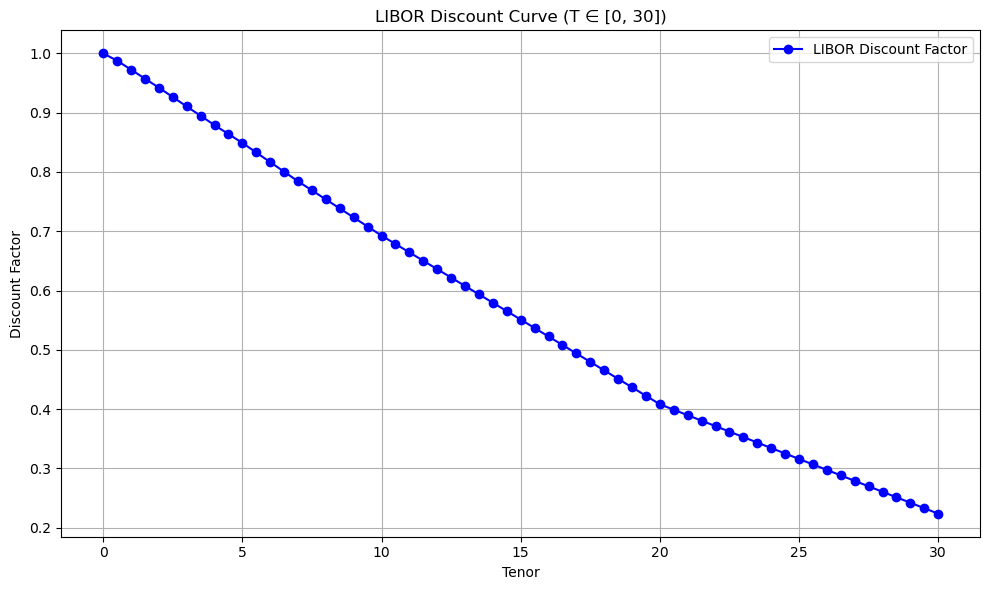

In [22]:
# Plot the LIBOR discount curve
plt.figure(figsize=(10, 6))

plt.plot(T2_values, 
         liborDiscFactor_all, 
         marker='o', 
         linestyle='-', 
         color='blue', 
         label='LIBOR Discount Factor'
        )
# B73508
plt.title("LIBOR Discount Curve (T ∈ [0, 30])")
plt.xlabel("Tenor")
plt.ylabel("Discount Factor")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Part 3.
Calculate the following forward swap rates:
>• $1y × 1y, 1y × 2y, 1y × 3y, 1y × 5y, 1y × 10y$
>
>• $5y × 1y, 5y × 2y, 5y × 3y, 5y × 5y, 5y × 10y$
>
>• $10y × 1y, 10y × 2y, 10y × 3y, 10y × 5y, 10y × 10y$

Note: Use linear interpolation on discount factors when necessary.

$$
\text{Forward Libor Rate} = \frac{\widetilde{D}(0, T_n) - \widetilde{D}(0, T_{n+0.5})}{\widetilde{D}(0, T_{n+0.5})}
$$

In [24]:
def calculate_forward_swap_rate(start_year, 
                                tenor, 
                                ois_discount, 
                                liborForwards):
    start = start_year
    end = start_year + tenor

    # indexes are 2*year+1 due to the construction of oisDiscFactors_all and
    # that year's discount factor is not taken into account 
    # => [d00, d06m, d01y, d01.5y, d02y, 02.5y ...] 
    # year1, first discount factor is d01.5y => 2*1+1 = 3
    # year2, first discount factor is d02.5y => 2*2+1 = 5 
    ois_disc_factors = ois_discount[start * 2 + 1 : end * 2 + 1]

    # denominator is the "fixed" = sum of ois_discount factors * daycount 
    # 0.5 is day fraction
    denominator = sum(ois_disc_factors) * 0.5 

    # start from the index of the first payment
    counter = start * 2 + 1 
    
    # numerator is the "float" leg
    numerator = 0
    
    # no need +1 because D(0, start) is not included
    for index in range(tenor*2):
        numerator += ois_discount[counter] * liborForwards[counter] * 0.5
        
        # advance to the next D
        counter += 1 
        
    return numerator/denominator

In [25]:
forwardSwaps = [(1,1),
                (1,2),
                (1,3),
                (1,5),
                (1,10),
                (5,1),
                (5,2),
                (5,3),
                (5,5),
                (5,10),
                (10,1),
                (10,2),
                (10,3),
                (10,5),
                (10,10)]

fwdSwapRatesDF = pd.DataFrame(columns=["Start","Tenor","liborForwardSwapRate"])
rows_list = []

for swap_combination in forwardSwaps:
    swapStart = swap_combination[0]
    swapTenor = swap_combination[1]
    
    swapRate =\
    (
        calculate_forward_swap_rate(swapStart, 
                                    swapTenor, 
                                    oisDiscFactor_all, 
                                    liborForwardRates
                                   )
    )
    
    newRow =\
    (
        pd
        .DataFrame({'Start':[str(swapStart)+"Y"], 
                    'Tenor':[str(swapTenor)+"Y"], 
                    'liborForwardSwapRate':[swapRate]}
                  )
    )
    
    rows_list.append(newRow)

fwdSwapRatesDF = pd.concat(rows_list, ignore_index=True)

df = pd.DataFrame(fwdSwapRatesDF)

# Pivot the DataFrame
pivot_df = df.pivot(index='Start', columns='Tenor', values='liborForwardSwapRate')

# Optional: sort the columns in a specific order (if needed)
pivot_df = pivot_df.loc[["1Y", "5Y", "10Y"], ["1Y", "2Y", "3Y", "5Y", "10Y"]]

print(pivot_df)

Tenor        1Y        2Y        3Y        5Y       10Y
Start                                                  
1Y     0.032007  0.033259  0.034011  0.035255  0.038428
5Y     0.039274  0.040075  0.040072  0.041093  0.043634
10Y    0.042190  0.043116  0.044097  0.046249  0.053458


In [26]:
# with pd.ExcelWriter("Data_1_Output.xlsx") as writer:
#     # Write each DataFrame to a separate sheet
#     oisDiscFactorsDF.to_excel(writer, sheet_name='oisDiscFactors', index=False)
#     liborDiscFactorsDF.to_excel(writer, sheet_name='liborDiscFactors', index=False)
#     fwdSwapRatesDF.to_excel(writer, sheet_name='fwdSwapRates', index=False)